In [1]:
import inputs
import refdata as ref
import isentropic_efficiency as isen

import numpy
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
inputs.refrigerant

'r744'

In [3]:
# Get evaporator temperature

if inputs.source_type == 'Air':
    evaporator_temp = inputs.source_temp - 6
elif inputs.source_type == 'Water':
    evaporator_temp = inputs.source_temp - 6
elif inputs.source_type == 'Advanced':
    evaporator_temp = inputs.source_temp - inputs.delta_T_source_evaporator

In [4]:
# Get condensor temperature

if inputs.sink_type == 'Air':
    condensor_temp = inputs.sink_temp + 12

elif inputs.sink_type == 'Water':
    delta_T_sink_condensor = 5
    supply_temp = inputs.sink_temp
    return_temp = inputs.sink_temp_return

    condensor_temp = (-(return_temp-supply_temp*numpy.exp((supply_temp
                      - return_temp)/delta_T_sink_condensor)) / (numpy.exp(
                      (supply_temp-return_temp) / delta_T_sink_condensor)-1)) \
                       + delta_T_sink_condensor

elif inputs.sinkType == 'Advanced':
    condensor_temp = inputs.sink_temp + inputs.delta_T_sink_condensor

In [5]:
# Compressor intake (suction line)
p1 = ref.pressure_saturated_liq_func(evaporator_temp)[()]
t1 = evaporator_temp + inputs.delta_T_superheat_suction
h1 = ref.enthalpy_superheated_func(inputs.delta_T_superheat_suction, p1)[0]

In [6]:
p1

35.8198

In [7]:
s1 = interpolate.bisplev(inputs.delta_T_superheat_suction, p1, ref.entropy_superheated_func)

if inputs.delta_T_superheat_suction == 0:
    x1 = 1                                  # vapor quality
else:
    x1 = '-'

In [8]:
# Compressor output (isentropic)
p2s = ref.pressure_saturated_gas_func(condensor_temp)
s2s = s1
dt2s = interpolate.bisplev(s2s, p2s, ref.dt_s_superheated_func)
t2s = condensor_temp + dt2s
x2s = '-'
h2s = ref.enthalpy_superheated_func(dt2s, p2s)[0]

In [9]:
pressureratio = p2s/p1
ideal = inputs.ideal_pressure_ratio

In [10]:
isentropic_efficiency = isen.getefficiency(pressureratio)

In [11]:
# Compressor output ('real')

p2 = p2s
h2 = h1 + (h2s-h1) / isentropic_efficiency
dt2 = interpolate.bisplev(h2, p2, ref.dt_h_superheated_func)
t2 = condensor_temp + dt2
s2 = interpolate.bisplev(dt2, p2, ref.entropy_superheated_func)[()]
x2 = '-'

In [12]:
# Expansion valve intake

p3 = p2

if ref.temp_gas_saturated.equals(ref.temp_liquid_saturated):
    zeotropic = False
    t3 = condensor_temp
else: 
    zeotropic = True
    t3 = ref.temp_liquid_saturated_func(p2)

h3 = ref.enthalpy_liquid_saturated_func(p3)
s3 = ref.entropy_liquid_saturated_func(p3)
x3 = 0

In [13]:
# Expansion valve outlet

p4 = p1
t4 = evaporator_temp
h4 = h3

hf = ref.enthalpy_liquid_saturated_func(p4)
hg = ref.enthalpy_gas_saturated_func(p1)
x4 = (h4-hf) / (hg-hf)

sf = ref.entropy_liquid_saturated_func(p4)
sg = ref.entropy_gas_saturated_func(p1)
s4 = sf + x4 * (sg-sf)

In [14]:
# Cop calculation

delta_h_compressor = (h2-h1) / (inputs.motor_efficiency/100)
delta_h_condensor = h2-h3
cop = delta_h_condensor/delta_h_compressor
cop_carnot = (condensor_temp+273.15) / (condensor_temp-evaporator_temp)
carnot_efficiency = cop / cop_carnot

In [15]:
# Creating table
reftable = pd.DataFrame(
    [
        ['1',t1, p1, h1, s1, x1], 
        ['2s', t2s, p2s, h2s, s2s, x2s], 
        ['2', t2, p2, h2, s2, x2], 
        ['3', t3, p3, h3, s3, x3], 
        ['4', t4, p4, h4, s4, x4]
    ]
)

reftable.columns = ['point', 'T (°C)', 'p (bar)', 'h (kJ/kg)', 
                's (kJ/kgK)', 'x']

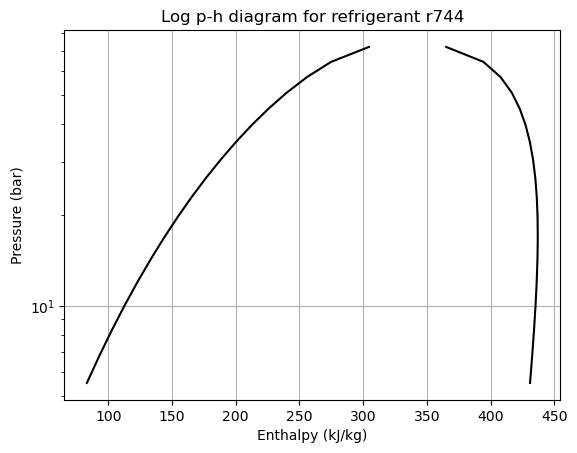

In [16]:
#plot log p-h saturation curve

fig, ax = plt.subplots()

toplot_h_liq = ref.enthalpy_liquid_saturated_func(ref.pressure_saturated)
toplot_h_gas = ref.enthalpy_gas_saturated_func(ref.pressure_saturated)
toplot_p = ref.pressure_saturated

ax.plot(toplot_h_liq, toplot_p, color='k')
ax.plot(toplot_h_gas, toplot_p, color='k')

plt.yscale('log')
plt.xlabel("Enthalpy (kJ/kg)")
plt.ylabel("Pressure (bar)")
plt.title("Log p-h diagram for refrigerant " + inputs.refrigerant)
plt.grid()

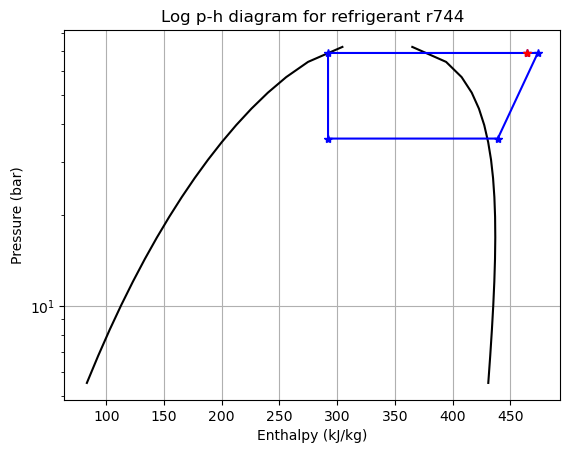

In [17]:
# Plot cycle

ax.plot(reftable['h (kJ/kg)'] , reftable['p (bar)'], '*b')
ax.plot([h1,h2,h3,h4,h1] , [p1,p2,p3,p4,p1], 'b')
ax.plot(h2s,p2s, '*r')
fig

In [18]:
# Flow rates etc

mass_flowrate_refrigerant = inputs.capacity/delta_h_condensor   	#kg/s
RHO_C = 4000
volume_rate_water = inputs.capacity / ((inputs.sink_temp - inputs.sink_temp_return)*RHO_C)
electric_power = inputs.capacity/cop

In [19]:
outputtable = pd.DataFrame(
    [
        ['COP',round(cop,2)],
        ['SCOP','-'],
        ['Carnot COP', round(cop_carnot,2)], 
        ['Carnot efficiency (%)', round(carnot_efficiency,1)*100], 
        ['Electric power (kW)', round(electric_power,1)], 
        ['Refrigerant mass flow rate (kg/s)', mass_flowrate_refrigerant],
        [ 'Water volume flow rate (kg/s)', volume_rate_water]
    ]   
)

In [20]:
outputtable

,0,1
0,COP,4.46
1,SCOP,-
2,Carnot COP,11.19
3,Carnot efficiency (%),40.0
4,Electric power (kW),2.2
5,Refrigerant mass flow rate (kg/s),0.055011
6,Water volume flow rate (kg/s),0.0005


In [21]:
inputs.inputtable

,0,1
0,Sink,Water
1,Source,Air
2,Sink temperature (°C),20
3,Sink temperature (return) (°C),15
4,Source temperature (°C),7
5,Refrigerant,r744
6,Capacity (kW),10


In [22]:
reftable

,point,T (°C),p (bar),h (kJ/kg),s (kJ/kgK),x
0,1,6.000000,35.8198,439.212736,1.86666,-
1,2s,54.643342,68.8785084300464,464.123129,1.86666,-
2,2,60.570905,68.8785084300464,473.887611,1.903991,-
3,3,27.909884,68.8785084300464,292.1054465634998,1.3032877871525859,0
4,4,1.000000,35.8198,292.1054465634998,1.335447,0.393507
